In [29]:
import math, collections
import matplotlib.pyplot as plt
import matplotlib.path
import numpy as np

# Create a simple polygon
hat = np.array([
    [0, 1], [0.5, 0], [2.5, 0], [3, 1], [4.5, 0],
    [6, 1], [5.5, 2], [4.5, 2], [4.5, 4], [3, 5],
    [2.5, 4], [1.5, 4], [1.5, 2],
])
hat -= [3, 1]

def draw(polygons, red_polygons=[]):
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))

    # Draw grid
    ax.set_xticks(np.arange(-10, 10, 1.0))
    ax.set_yticks(np.arange(-10, 10, 1.0))
    ax.grid(True, which='both', color='lightgray', linestyle='--', linewidth=0.5)

    # Plot polygon
    for (color_outline, color_inside, fill_alpha, polygon_list) in [
        ("blue", "skyblue", 0.4, polygons),
        ("red", "red", 0.0, red_polygons),
    ]:
        for polygon in polygon_list:
            polygon_closed = np.vstack([polygon, polygon[0]])  # Close the polygon
            ax.plot(polygon_closed[:,0], polygon_closed[:,1], color=color_outline, linewidth=2)
            ax.fill(polygon_closed[:,0], polygon_closed[:,1], color=color_inside, alpha=fill_alpha)
        
    ax.invert_yaxis()
    ax.set_aspect('equal')

    # Show plot
    plt.show()

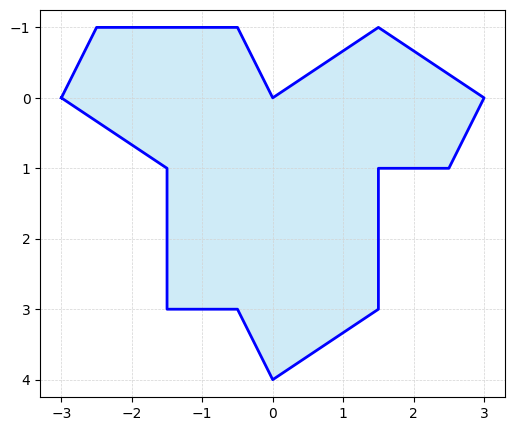

In [30]:
draw([hat])

In [3]:
def segments_intersect(p1, p2, q1, q2):
    def orientation(a, b, c):
        return (b[0]-a[0])*(c[1]-a[1]) - (b[1]-a[1])*(c[0]-a[0])

    def on_segment(a, b, c):
        return min(a[0], c[0]) <= b[0] <= max(a[0], c[0]) and \
               min(a[1], c[1]) <= b[1] <= max(a[1], c[1])

    o1 = orientation(p1, p2, q1)
    o2 = orientation(p1, p2, q2)
    o3 = orientation(q1, q2, p1)
    o4 = orientation(q1, q2, p2)

    # General case
    if o1*o2 < 0 and o3*o4 < 0:
        return True

    # Collinear cases
    if o1 == 0 and on_segment(p1, q1, p2): return False
    if o2 == 0 and on_segment(p1, q2, p2): return False
    if o3 == 0 and on_segment(q1, p1, q2): return False
    if o4 == 0 and on_segment(q1, p2, q2): return False

    return False

In [9]:
def polygon_edges_intersect(a: np.ndarray, b: np.ndarray) -> bool:
    for i in range(len(a)):
        for j in range(len(b)):
            if segments_intersect(
                a[i],
                a[(i+1)%len(a)],
                b[j],
                b[(j+1)%len(b)],
            ):
                return True
    return False

def polygon_contains(poly_a: np.ndarray, poly_b: np.ndarray) -> bool:
    if polygon_edges_intersect(poly_a, poly_b):
        return True
    path_a = matplotlib.path.Path(poly_a)
    return path_a.contains_point(poly_b[0])

In [10]:
polygon_contains(hat, hat)

True

In [11]:
def apply_isometry(polygon: np.ndarray, n: int) -> np.ndarray:
    assert 0 <= n < 12
    polygon = polygon.copy()
    if n >= 6:
        polygon *= [-1, 1]
    angle = (n % 6) * 2 * math.pi / 6
#     polygon *= [2/3**0.5, 1]
    s, c = math.sin(angle), math.cos(angle)
    polygon = polygon @ [[c, -s], [s, c]]
#     polygon /= [2/3**0.5, 1]
    return polygon

In [12]:
def make_polygon(dx, dy, n: int) -> np.ndarray:
    poly = hat.copy()
    poly *= [2/3**0.5, 1]
    poly = apply_isometry(poly, n)
    poly /= [2/3**0.5, 1]
    poly += [dx, dy]
    return poly

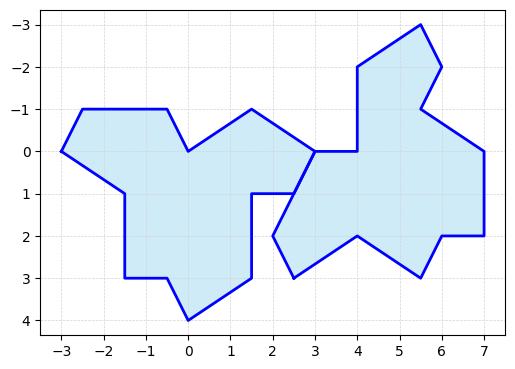

In [13]:
draw([make_polygon(0, 0, 0), make_polygon(4, 0, 1)])

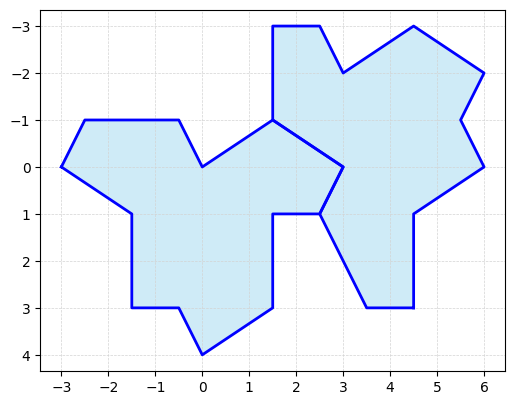

In [17]:
squishy = hat.copy()
squishy *= [2/3**0.5, 1]
squishy = apply_isometry(squishy, 2)
squishy /= [2/3**0.5, 1]
draw([hat, squishy + np.array([3, 0])])

In [18]:
from pysat.formula import CNF
from pysat.solvers import Solver

In [40]:
%%time

var_counter = 0

var_to_state = {}
for dx in range(4):
    for dy in range(4):
        for iso in range(12):
            var_counter += 1
            new_var = var_counter
            new_poly = make_polygon(dx, dy, iso)
            var_to_state[new_var] = dx, dy, iso, new_poly 

var_to_square = {}
for dx in range(0, 8, 2):
    for dy in range(0, 8, 2):
        var_counter += 1
        new_var = var_counter
        new_poly = np.array([[0.1, 0.1], [1.9, 0.1], [1.9, 1.9], [0.1, 1.9]]) + [dx, dy]
        var_to_square[new_var] = dx, dy, new_poly

base_clauses = []
all_pairs = list(var_to_state.items())
for i, (var_a, (_, _, _, poly_a)) in enumerate(all_pairs):
    for var_b, (_, _, _, poly_b) in all_pairs[:i]:
        if polygon_edges_intersect(poly_a, poly_b):
            base_clauses.append([-var_a, -var_b])

guys_who_intersect_this_square = collections.defaultdict(list)
for placement_var, (_, _, _, polygon) in var_to_state.items():
    for filled_var, (_, _, square) in var_to_square.items():
        if polygon_contains(polygon, square):
            guys_who_intersect_this_square[filled_var].append(placement_var)
            base_clauses.append([-placement_var, filled_var])

for filled_var, placement_var_list in guys_who_intersect_this_square.items():
    base_clauses.append([-filled_var] + placement_var_list)

CPU times: user 2.54 s, sys: 7.17 ms, total: 2.55 s
Wall time: 2.55 s


In [41]:
clauses = base_clauses.copy()
for filled_var in var_to_square:
    clauses.append([filled_var])

Selected: [37, 100, 181, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208]


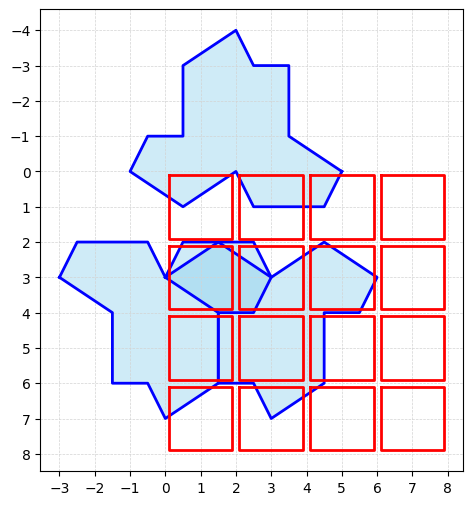

In [42]:
cnf = CNF(from_clauses=clauses)
with Solver(bootstrap_with=cnf) as solver:
    assert solver.solve(), "Not satisfiable!"
    model = [x for x in solver.get_model() if x > 0]
    print("Selected:", model)
draw(
    [
        var_to_state[var][-1] for var in model
        if var in var_to_state
    ],
    [
        var_to_square[var][-1] for var in model
        if var in var_to_square
    ],
)